In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import directory_functions as dirfuncs
import gather_middleware_statistics as gmws
import cut_away_warmup_cooldown as cut

exp_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453"

In [2]:
# Get response times from MW for 6 multigets
def gather_requests(exp_dir, reps, middlewares):
    all_reps = []
    for rep in reps:

        middleware_dirs = [dirfuncs.get_only_subdir(os.path.join(exp_dir, str(rep), mw_dir)) for mw_dir in middlewares]
        concatenated_requests = [gmws.concatenate_requestlogs(middleware_dir) for middleware_dir in middleware_dirs]


        
        metrics = [gmws.extract_metrics(reqs) for reqs in concatenated_requests]


        cut_metrics = [cut.cut_away_warmup_cooldown(mets, 10, 72) for mets in metrics]

        all_reps.extend(cut_metrics)
        
    return pd.concat(all_reps)


In [3]:
# What should be the granularity of the memtier response time interpolation?
granularity = 0.1

# Extract GET histogram from single memtier logfile
def parse_line(line):
    split = line.split()
    return (split[1], split[2])
def extract_GET_histogram(client_logfile_path):
    with open(client_logfile_path, "r") as logfile:
        return [parse_line(line)for line in logfile if line.startswith("SET")]
def extract_GET_throughput(client_logfile_path):
    with open(client_logfile_path, "r") as logfile:
        for line in logfile:
            if line.startswith("Sets"):
                split_line = line.split()
                return float(split_line[1])
def interpolate_histogram(hist, granularity):
    rowcount = hist.shape[0]
    desired_steps = np.arange(start=hist[0, 0], stop=hist[rowcount-1, 0], step=granularity)
    return desired_steps, np.interp(desired_steps, hist[:,0], hist[:,1])
def calculate_numrequests(interpolated, xput, granularity):
    interpolated = np.vstack(interpolated).transpose()
    sorted = interpolated[interpolated[:,0].argsort()]

    shifted = np.hstack([sorted[:-1,:], sorted[1:,:]])
    shifted_frame = pd.DataFrame(data=shifted, columns=['responsetime_unshifted', 'percentile_unshifted', 'responsetime', 'percentile'])
    shifted_frame['num_requests'] = shifted_frame['percentile'] * xput / 100
    shifted_frame['num_requests_unshifted'] = shifted_frame['percentile_unshifted'] * xput / 100
    shifted_frame['requests'] = (shifted_frame['num_requests'] - shifted_frame['num_requests_unshifted'])

    return shifted_frame.loc[:, ['responsetime', 'percentile', 'requests']]
def combine_multiple_histograms(histogram_arrays, throughputs, granularity):
    interpolated = [interpolate_histogram(hist, granularity) for hist in histogram_arrays]
    interpolated_with_numrequests = [calculate_numrequests(interp, xput, granularity) for interp, xput in zip(interpolated, throughputs)]
    return pd.concat(interpolated_with_numrequests).groupby('responsetime').agg({'requests': 'sum'}).reset_index()

def wquantile(x,q):           
    xsort = x.sort_values(x.columns[0])
    xsort['index'] = range(len(x))
    p = q * x[x.columns[1]].sum()
    pop = float(xsort[xsort.columns[1]][xsort['index']==0])
    i = 0
    while pop < p:
        pop = pop + float(xsort[xsort.columns[1]][xsort['index']==i+1])
        i = i + 1
    return xsort[xsort.columns[0]][xsort['index']==i]

def extract_percentiles(data, percentiles):
    percentile_list = []
    percentile_list.extend([(perc, wquantile(data, perc).values[0]) for perc in percentiles])
    return pd.DataFrame(data=percentile_list, columns=['percentile', 'responsetime'])

In [4]:
num_workers = 8
run = "writeOnly_32vc{}workers".format(num_workers)
inputdir = os.path.join(exp_dir, run)

                        
reps_range = range(1, 4)
middlewares = ["middleware_04", "middleware_05"]
reqs = gather_requests(inputdir, reps_range, middlewares)

# Extracting histograms for Sharded
client_logfiles = ["client_01_0.log", "client_01_1.log", "client_02_0.log", "client_02_1.log", "client_03_0.log", "client_03_1.log"]
reps = 3
filepaths = [os.path.join(inputdir, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles]
histograms = [np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths]
throughputs = [extract_GET_throughput(filepath) for filepath in filepaths]
hist_data = combine_multiple_histograms(histograms, throughputs, granularity)


Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/1/middleware_04/2017-11-29 174633
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/1/middleware_05/2017-11-29 174634
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/2/middleware_04/2017-11-29 185713
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/2/middleware_05/2017-11-29 185714
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/3/middleware_04/2017-11-29 200752
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_16

In [5]:
all_reps = []
for rep in reps_range:

    log_folder_path = os.path.join(inputdir, str(int(rep)))

    # Now we extract throughput, responsetime, average queuetime and missrate from the middleware
    middleware_dirs = [dirfuncs.get_only_subdir(os.path.join(log_folder_path, mw_dir)) for mw_dir in middlewares]
    concatenated_requests = [gmws.concatenate_requestlogs(middleware_dir) for middleware_dir in middleware_dirs]
    metrics = [gmws.extract_metrics(reqs) for reqs in concatenated_requests]
    cut_metrics = [cut.cut_away_warmup_cooldown(mets, 10, 72) for mets in metrics]
    windows = [gmws.aggregate_over_windows(cut_mets) for cut_mets in cut_metrics]
    rep_metrics = gmws.aggregate_over_middlewares(windows)
    all_reps.append(rep_metrics)

mw_agg_over_reps = gmws.aggregate_over_reps(all_reps)
mw_averages = gmws.aggregate_over_timesteps(mw_agg_over_reps)
avg = mw_averages.loc['mean', :]

Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/1/middleware_04/2017-11-29 174633
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/1/middleware_05/2017-11-29 174634
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/2/middleware_04/2017-11-29 185713
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/2/middleware_05/2017-11-29 185714
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_165453/writeOnly_32vc8workers/3/middleware_04/2017-11-29 200752
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp4/4_detailedrun_two_2017-11-29_16

In [6]:
arrivalrate_lambda = avg['throughput_mw']
servicerate_mu = 8215 # The maximum throughput ever observed
trafficIntensity_roh = arrivalrate_lambda / servicerate_mu
interarrivalTime_tao = 1000 / arrivalrate_lambda
servicetime_s = 1000 / servicerate_mu
mean_number_jobs_in_system = trafficIntensity_roh/(1-trafficIntensity_roh) # Compare with worker count
mean_number_jobs_in_queue = trafficIntensity_roh**2/(1-trafficIntensity_roh) # Compare with worker count
def cumulative_responsetime_distribution(r):
    return 1 - np.exp(-r*servicerate_mu*(1-trafficIntensity_roh))
mean_response_time_r = 1000 * (1/servicerate_mu)/(1-trafficIntensity_roh) # Compare with mean response time of client or middleware
def percentile_of_responsetimes(q): # Compare with 
    return mean_response_time_r*np.log(100/(100-q))
mean_waiting_time_w = 1000 * trafficIntensity_roh*(1/servicerate_mu)/(1-trafficIntensity_roh) #  Compare with queue time

Arrival Rate Lambda: Predicted: 8146.666666666666, Actual Throughput: 8146.666666666666
Service Rate Mu: Predicted: 8215
Traffic Intensity roh / Utilization: Predicted: 0.9917
Interarrival Time: Predicted: 0.1227, Actual interarrival time: 0.2393
Worker Service Time: Predicted: 0.1217, Actual worker service time: 1.9119
Number of Jobs in System: Predicted: 119.2195, Actual Num Workers: 8.0000
Number of Jobs in Queue: Predicted: 118.2278, Actual Queue Length: 80.6430
Mean Response Time r: Predicted: 14.6341, Actual Response Time (Middleware): 21.8102
Mean Waiting Time w: Predicted: 14.5124, Actual Queue Waiting Time: 19.8842


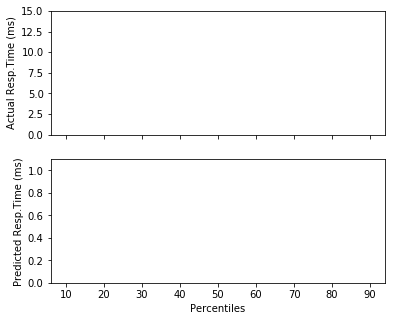

In [7]:
print("Arrival Rate Lambda: Predicted: {}, Actual Throughput: {}".format(arrivalrate_lambda, avg['throughput_mw']))
print("Service Rate Mu: Predicted: {}".format(servicerate_mu))
print("Traffic Intensity roh / Utilization: Predicted: {:0.4f}".format(trafficIntensity_roh))
print("Interarrival Time: Predicted: {:0.4f}, Actual interarrival time: {:0.4f}".format(interarrivalTime_tao, reqs['interarrivalTime_ms'].mean()))
actual_workerServiceTime_ms = (reqs['workerPreProcessingTime_ms'] + reqs['memcachedRTT_ms'] + reqs['workerPostProcessingTime_ms']).mean()
print("Worker Service Time: Predicted: {:0.4f}, Actual worker service time: {:0.4f}".format(servicetime_s, actual_workerServiceTime_ms))
print("Number of Jobs in System: Predicted: {:0.4f}, Actual Num Workers: {:0.4f}".format(mean_number_jobs_in_system, num_workers))
print("Number of Jobs in Queue: Predicted: {:0.4f}, Actual Queue Length: {:0.4f}".format(mean_number_jobs_in_queue, avg['queueLength']))
print("Mean Response Time r: Predicted: {:0.4f}, Actual Response Time (Middleware): {:0.4f}".format(mean_response_time_r, avg['responseTime_ms']))
print("Mean Waiting Time w: Predicted: {:0.4f}, Actual Queue Waiting Time: {:0.4f}".format(mean_waiting_time_w, avg['queueTime_ms']))

desired_percentiles = range(10, 100, 10)
memtier_percentiles = extract_percentiles(hist_data, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
responsetime_percentiles = [percentile_of_responsetimes(perc) for perc in desired_percentiles]

fig, axes = plt.subplots(2, sharex=True, figsize=(6,5))
axes[0].plot(desired_percentiles, memtier_percentiles['responsetime'], marker='o', color='#e34a33')
axes[1].plot(desired_percentiles, responsetime_percentiles, marker='o', color='#fc8d59')
axes[0].set_ylim([0,15])
axes[1].set_ylim([0,1.1])
axes[0].set_ylabel("Actual Resp.Time (ms)")
axes[1].set_ylabel("Predicted Resp.Time (ms)")
axes[1].set_xlabel("Percentiles")
axes[0].set_title("")
plt.show()
fig.savefig("./graphs/mm1_percentiles_{}workers".format(num_workers), dpi=300)